In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import pyfiles.lib as lib

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize([0.5], [0.5])])

mnist_traindataset = torchvision.datasets.MNIST(root='./data', 
                                                train=True, 
                                                download=True, 
                                                transform=transform)

mnist_testdataset = torchvision.datasets.MNIST(root='./data', 
                                               train=False, 
                                               download=True,
                                               transform=transform)

In [8]:
num_noise = batch_size = 128
epochs = 200

In [20]:
class Discriminator(torch.nn.Module):
    """
    Discriminator Class for GAN
    """
    def __init__(self, input_node_size=28*28, hidden_node_size=256, output_node_size=1):
        super(Discriminator, self).__init__()
        
        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        _x = x.view(x.shape[0], -1)
        return self.network(_x).view(-1, 1)
    
    
class Generator(torch.nn.Module):
    """
    Generator Class for GAN
    """
    def __init__(self, input_node_size, hidden_node_size=256, output_node_size=28*28):
        super(Generator, self).__init__()
        #self.num_noise = num_noise
        self.network = torch.nn.Sequential(
            
            torch.nn.Linear(input_node_size, hidden_node_size),
            #torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_node_size, hidden_node_size),
            #torch.nn.BatchNorm1d(num_features = hidden_node_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_node_size, output_node_size),
            torch.nn.Tanh()
            
        )
        
    def forward(self, x):
        return self.network(x).view((x.shape[0], 1, 28, 28))

(3, 92, 242)


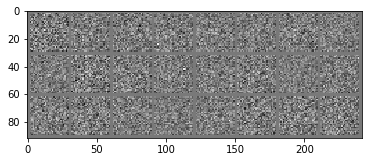

(3, 92, 242)


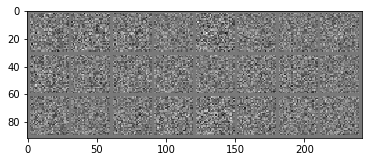

(3, 92, 242)


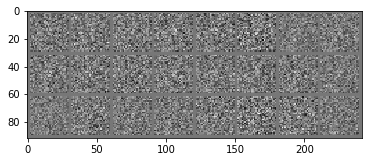

(3, 92, 242)


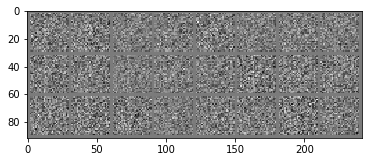

(3, 92, 242)


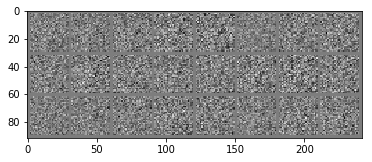

(3, 92, 242)


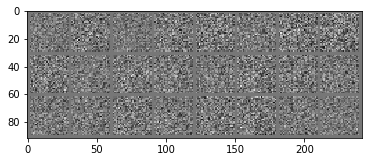

(3, 92, 242)


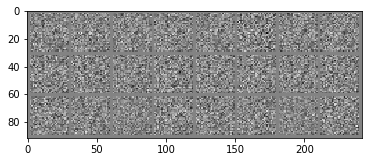

(3, 92, 242)


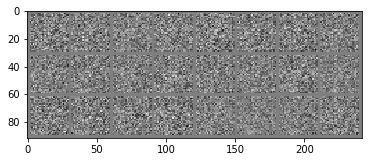

(3, 92, 242)


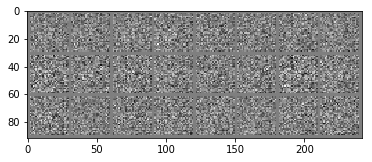

(3, 92, 242)


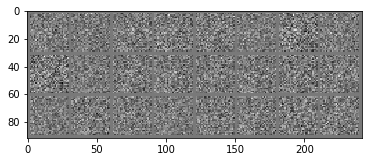

In [9]:
gen = Generator(N_noise, 256, 784)

if torch.cuda.is_available():
    gen = gen.cuda()
    
for i in range(10):
    noise = lib.sample_noise(24, num_noise).cuda()
    
    lib.imshow_grid(gen(noise))

tensor([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
          nan, nan, nan, nan, nan],
         [nan, nan, nan, nan, nan,

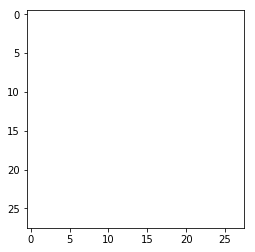

KeyboardInterrupt: 

In [21]:
traindataloader = torch.utils.data.DataLoader(mnist_traindataset, batch_size=batch_size, shuffle=True)
testdataloader = torch.utils.data.DataLoader(mnist_testdataset, batch_size=batch_size, shuffle=True)

disc = Discriminator(784, 256, 1)
gen = Generator(N_noise, 256, 784)
bceloss = torch.nn.BCELoss()

if torch.cuda.is_available():
    disc = disc.cuda()
    gen = gen.cuda()
    bceloss = bceloss.cuda()

disc_optim = torch.optim.Adam(disc.parameters(), lr=0.002)
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.002)

for epoch in range(epochs):
    running_loss = 0.0
    gen.train()
    disc.train()
    
    for i, data in enumerate(traindataloader):
        x, _ = data
        x = x.view(-1, 784)
        b_size = x.shape[0]
        
        noise = lib.sample_noise(b_size, N_noise)
        ones = torch.ones((b_size, 1))
        zeros = torch.zeros((b_size, 1))
            
        if torch.cuda.is_available():
            x = x.cuda()
            noise = noise.cuda()
            ones = ones.cuda()l
            zeros = zeros.cuda()
            
        disc_optim.zero_grad()
        gen_optim.zero_grad()
        gen_image = gen(noise)
        
        ### Learn Discriminator 
        p_fake = disc(gen_image.detach())
        p_real = disc(x)
        
        loss_d = -torch.mean(torch.log(p_real) + torch.log(1 - p_fake))
        #loss_d = bceloss(p_fake, ones) + bceloss(p_real, zeros)
        loss_d.backward()
        disc_optim.step()
        
        ### Learn Generator
        p_fake = disc(gen_image)
        
        loss_g = -torch.mean(torch.log(p_fake))
        #loss_g = bceloss(p_fake, ones)
        loss_g.backward()
        gen_optim.step()
        #print("Discriminator Loss: %.3f | Generator Loss: %.3f" % (loss_d.item(), loss_g.item()))
        
    if epoch % 10 == 9:
        gen.eval()
        noise = lib.sample_noise(24, N_noise)
        if torch.cuda.is_available():
            noise = noise.cuda()

        gen_img = gen(noise)
        print(gen_img[0])
        lib.imshow(gen_img[0].cpu().detach())
        lib.imsave(gen_img, epoch)
        